In [65]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
%pylab inline
#import choroplethNYC as cp
try:
    import urllib2
except ImportError:
    import urllib
import os
import requests
import json
import sys
import io

Populating the interactive namespace from numpy and matplotlib


In [2]:
#add cwd to system path in order have it look up the census API file
sys.path.append(os.getcwd())

In [3]:
from censusAPI import myAPI

success!


### 1.1 Trap some PUMAs from OpenData API

In [4]:
#make PUIDATA an environment variable if it isn't already
#Ilyas! Somehow my environmental variable for PUIData is pointing to a different thing by default which is messing everything up..
if os.getenv("PUIDATA") == "/nfshome/mrn291/PUIdata":
    del os.environ['PUIDATA']
    
if os.getenv("PUIDATA") == None:
    os.environ["PUIDATA"] = "%s/PUIData"%os.getenv("HOME")

In [5]:
#change working directory to PUIDATA
os.chdir(os.getenv("PUIDATA"))
os.getcwd()

'/nfshome/mrn291/PUIData'

In [6]:
#url to download
puma_download = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

In [7]:
#download the url
if os.path.isfile(os.getenv("PUIDATA") + "/puma_shapes.zip"):
    print("Data already there!")
else:
    urllib.request.urlretrieve(puma_download, "puma_shapes.zip")
    os.system("unzip " + os.getenv("PUIDATA") + "/puma_shapes.zip")

Data already there!


In [8]:
#read in shapefile
shapefile = 'geo_export_d0564880-391d-4f7c-9314-650d8a5dfd03.shp'
puma_shapes = gpd.GeoDataFrame.from_file(shapefile)

In [9]:
#look at the dataframe
puma_shapes.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [10]:
puma_shapes.groupby('puma').count()

,shape_area,shape_leng,geometry
puma,,,
3701,1,1,1
3702,1,1,1
3703,1,1,1
3704,1,1,1
3705,1,1,1
3706,1,1,1
3707,1,1,1
3708,1,1,1
3709,1,1,1


### 1.2 Map those PUMAs

In [11]:
puma_shapes.crs

{'init': 'epsg:4326'}

In [12]:
#reproject to north american equidistant conic to better fit nyc
naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

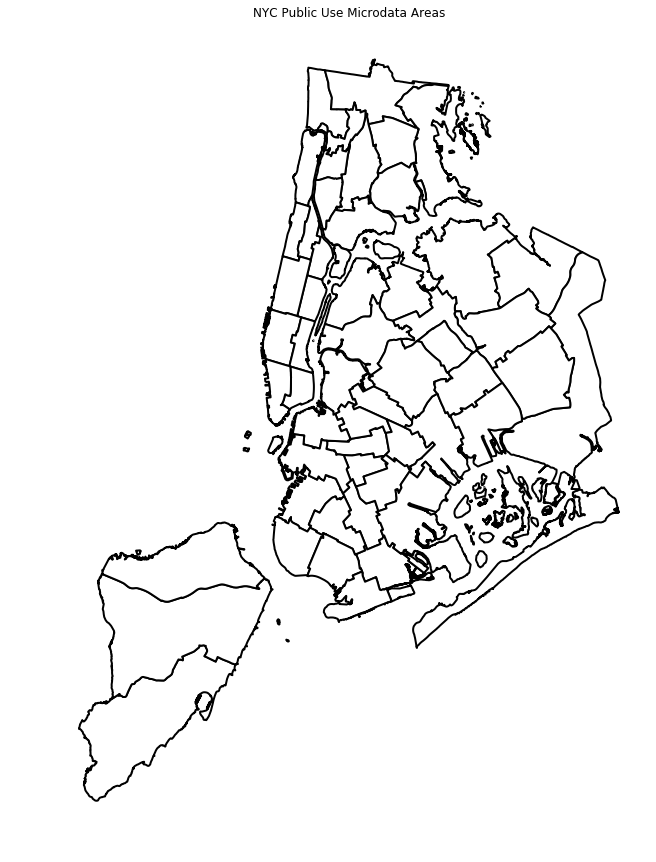

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')
plt.title("NYC Public Use Microdata Areas")
puma_shapes.to_crs(naec).plot(ax=ax, color='white', edgecolor='black', lw=2)
plt.show()


Map showing the Public Use Microdata Areas (PUMA) for New York City.

### 2.1 Get Data with the American Fact Finder API

In [14]:
#read in in the variables available. the info you need is in the 1 year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [15]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

In [16]:
affkeys.size
#whoa

31710

In [17]:
#find the broadband keys
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription')]

In [18]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [19]:
#keyword for the number of households with broadband
keyBBhouseholds = 'B28002_004E'
aff1y['variables'][keyBBhouseholds]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [20]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyBBhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [21]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaHH = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaHH.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


### 2.2 Generate a feature for the percentage of households with broadband access.

In [22]:
puma_total = pd.merge(pumaHH, pumaBB, on=['state', 'public use microdata area', 'NAME'])

In [23]:
puma_total.drop(labels=['Unnamed: 4_x', 'Unnamed: 4_y'], axis=1, inplace=True)
puma_total.rename(columns={'B28002_001E':'Total_HH', 'B28002_004E':'BB_HH', 'public use microdata area':'puma'}, inplace=True)
puma_total['BB_Percent'] = (puma_total['BB_HH'] / puma_total['Total_HH'].astype(float) * 100)

In [24]:
puma_total.head()

,Total_HH,NAME,state,puma,BB_HH,BB_Percent
0,40479,"St. Lawrence County PUMA, New York",36,100,32607,80.552879
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,50811,75.733321
2,51614,"Warren & Washington Counties PUMA, New York",36,300,41210,79.842678
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,36075,81.433409
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,47786,78.150656


In [25]:
puma_total.groupby('puma').count()

,Total_HH,NAME,state,BB_HH,BB_Percent
puma,,,,,
100,1,1,1,1,1
200,1,1,1,1,1
300,1,1,1,1,1
401,1,1,1,1,1
402,1,1,1,1,1
403,1,1,1,1,1
500,1,1,1,1,1
600,1,1,1,1,1
701,1,1,1,1,1


### 2.3 Compare calculated percent with the AFF published "percentage of households with broadband access."

In [26]:
#change working directory to PUIDATA
os.chdir(os.getenv("PUIDATA"))
os.getcwd()

'/nfshome/mrn291/PUIData'

In [27]:
#unzip the data
os.system("unzip " + os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50.zip")

256

In [28]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"], skiprows=[1])
bbpc.rename(columns={'GCT_STUB.target-geo-id2':'puma'}, inplace=True)
bbpc.head()

,puma,HC01,HC02
0,1,74.7,0.5
1,100100,70.9,2.5
2,100200,80.5,2.7
3,100301,87.0,2.8
4,100302,81.9,2.9


In [29]:
bbpc.groupby('puma').count()

,HC01,HC02
puma,,
1,1,1
2,1,1
4,1,1
5,1,1
6,1,1
8,1,1
9,1,1
10,1,1
11,1,1


In [30]:
bbpc = bbpc[(bbpc['puma'] > 3600000) & (bbpc['puma'] < 5700000)]
bbpc.puma = bbpc.puma - 3600000
bbpc.puma.dtype

dtype('int64')

In [31]:
bbpc.shape

(972, 3)

In [32]:
bbpc.dtypes

puma      int64
HC01    float64
HC02    float64
dtype: object

In [33]:
bbpc.groupby('puma').count()

,HC01,HC02
puma,,
100,1,1
200,1,1
300,1,1
401,1,1
402,1,1
403,1,1
500,1,1
600,1,1
701,1,1


#### Check to see if the diffs generated are the same

In [34]:
# merging on PUMA code
diff = puma_total.merge(bbpc, on='puma')[["BB_Percent", "HC01"]]

diff["diff"] = np.abs(diff["BB_Percent"] - diff["HC01"].astype(float))

diff.describe()

,BB_Percent,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


### 3. Plot a choropleth of NYC broadband access

In [43]:
puma_shapes['puma'] = puma_shapes['puma'].astype(int64)

In [44]:
puma_broadband = puma_shapes.merge(puma_total, on='puma')

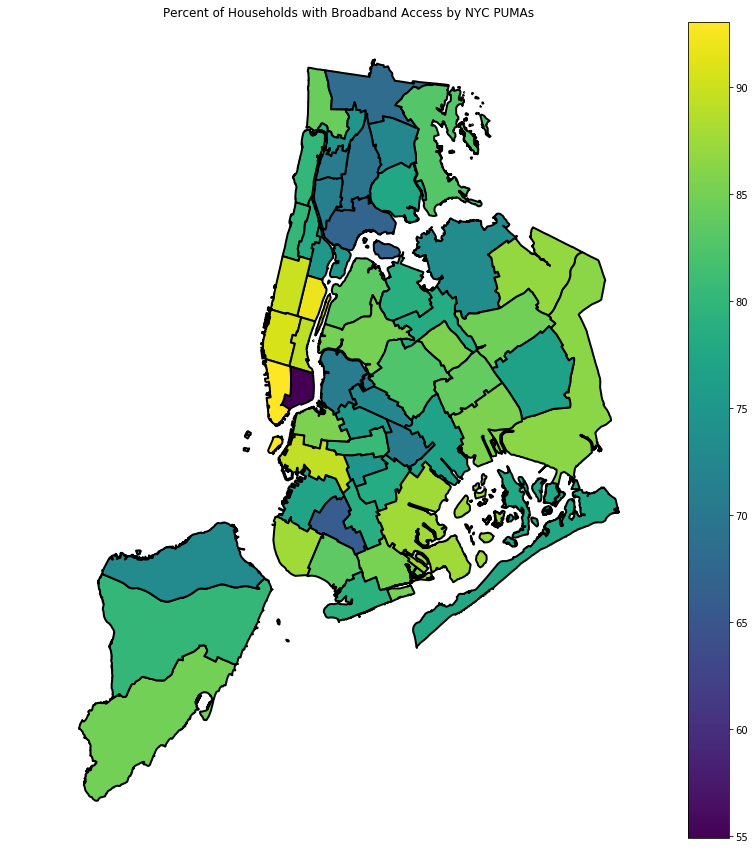

In [66]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
ax.axis('off')
plt.title("Percent of Households with Broadband Access by NYC PUMAs")
puma_broadband.to_crs(naec).plot(ax=ax, cmap='viridis', column='BB_Percent', edgecolor='black', lw=2, legend=True)
#im = ax.imshow(puma_broadband['BB_Percent'], cmap='viridis')
#cax = divider.append_axes('right', size='5%', pad=0.05)
#cbar = fig.colorbar(im, ax=ax)
plt.show()

Figure showing the percentage of households in a given Public Use Microdata Area with access to any kind of broadband.